In [120]:
%matplotlib inline
%pwd

'/home/gabe/work/fast-ai/nbs'

In [121]:
%%html
<style>
  .end_space {
      min-height: 1000px;
  }
  .container {
      width: 100%;
  }
</style

In [122]:
import sys
import os
import tarfile
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from six.moves import urllib
from importlib import reload
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from os import listdir, makedirs
from os.path import join, abspath, exists, isdir, isfile

np.random.seed(seed=2017)
sys.path.append('../src')

In [123]:
import utils.utils
reload(utils.utils)

import utils.train_helper
reload(utils.train_helper)

import utils.mix_iterator
reload(utils.mix_iterator)

import utils.housing_helper
reload(utils.housing_helper)

from utils.train_helper import save_model, read_model, get_classes, get_batches, get_data, un_onehot
from utils.utils import save_array, load_array, read_img, get_steps, do_clip
from utils.mix_iterator import MixIterator
from utils.housing_helper import CombinedAttributesAdder, DataFrameSelector, CategoricalEncoder

In [160]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam, Nadam
from keras.regularizers import l2
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import xception, inception_v3
from keras.utils import to_categorical as onehot

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.externals import joblib

In [125]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
DOWNLOAD_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'
DATA_DIR = '../data/housing'

BATCH_SIZE = 64
IMG_SIZE = 299
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
TARGET_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

POOLING = 'avg'
NUM_CLASSES = 120
SEED = 1987

In [126]:
def fetch_housing_data(url, data_dir):
    mkdir(data_dir)
    tgz_path = join(data_dir, 'housing.tgz')
    urllib.request.urlretrieve(url, tgz_path)
    
    tgz = tarfile.open(tgz_path)
    tgz.extractall(path=data_dir)
    tgz.close()

In [127]:
def load_housing_data(data_dir):
    csv_path = join(data_dir, 'housing.csv')
    return pd.read_csv(csv_path)

In [128]:
# fetch_housing_data(DOWNLOAD_URL, DATA_DIR)

In [129]:
housing_data = load_housing_data(DATA_DIR) 
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [130]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [131]:
housing_data.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [132]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


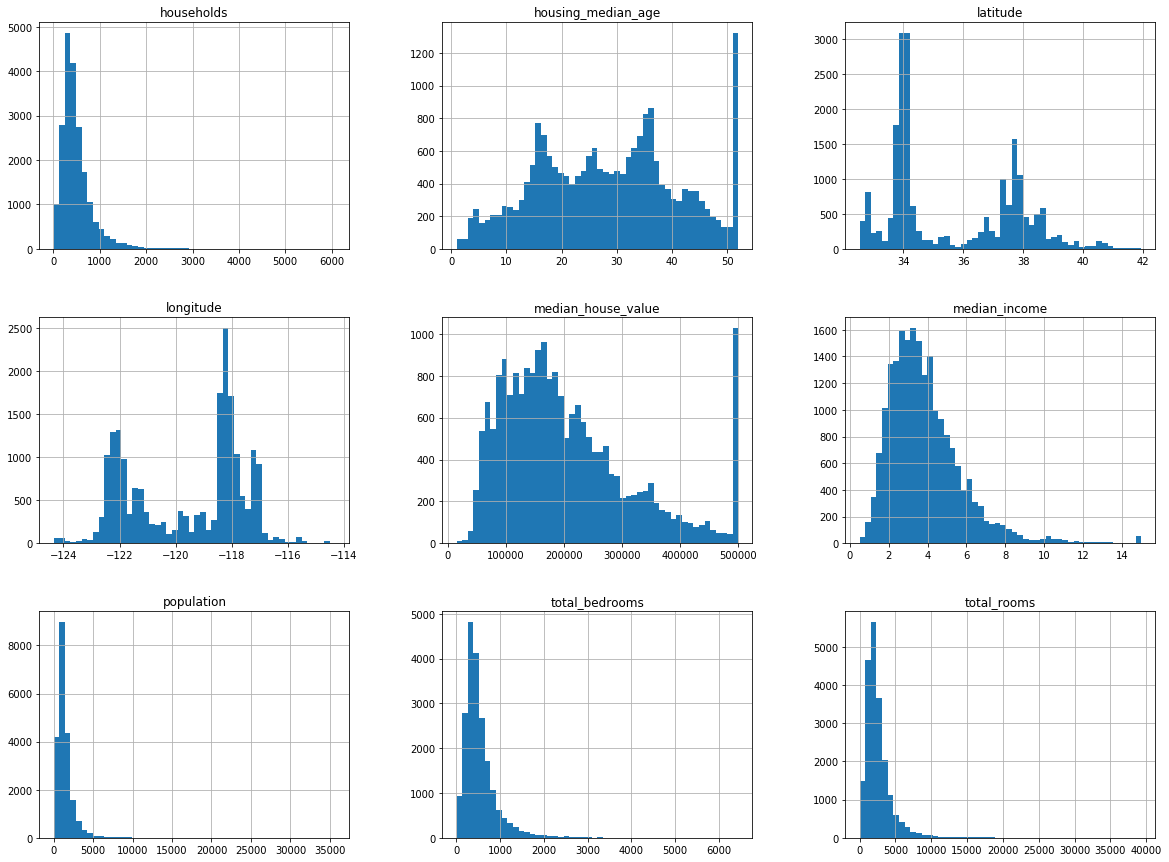

In [133]:
housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

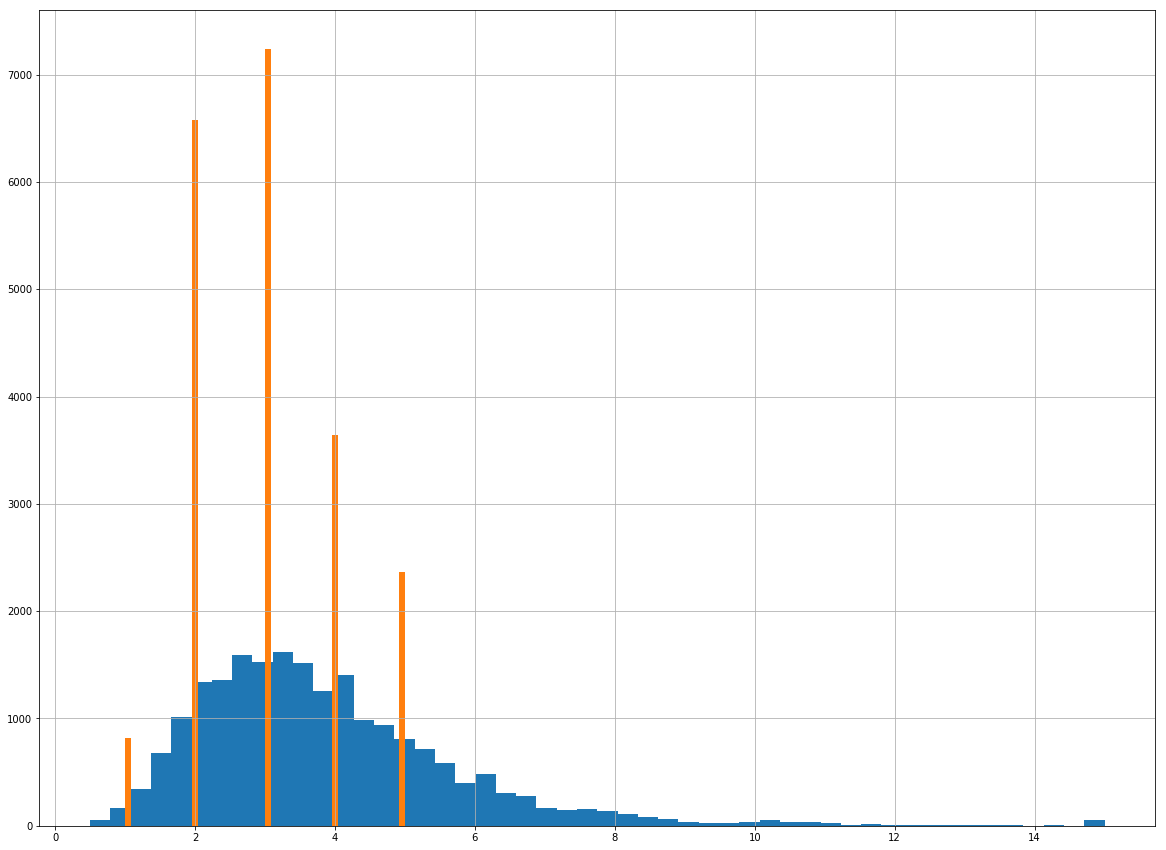

In [134]:
housing_data['income_cat'] = np.ceil(housing_data.median_income / 1.5)
housing_data.income_cat.where(housing_data.income_cat < 5, 5.0, inplace=True)
housing_data.median_income.hist(bins=50, figsize=(20, 15))
housing_data.income_cat.hist(bins=50, figsize=(20, 15))

In [135]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2017)
for train_index, test_index in split.split(housing_data, housing_data.income_cat):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [136]:
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=2017)

In [137]:
for s in (strat_train_set, strat_test_set):
    s.drop('income_cat', axis=1, inplace=True)

In [138]:
strat_train_set_copy = strat_train_set.copy()

### Density areas

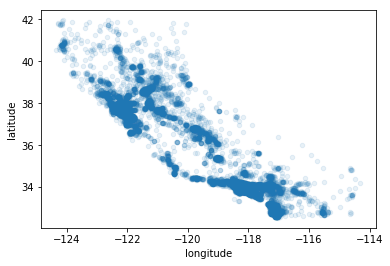

In [139]:
strat_train_set_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

### Prices

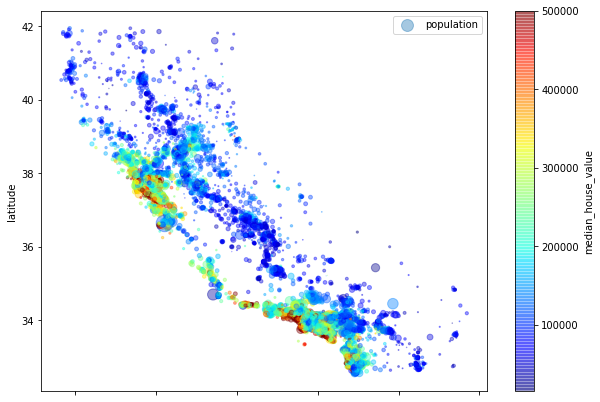

In [140]:
strat_train_set_copy.plot(kind='scatter', 
                          x='longitude', 
                          y='latitude', 
                          alpha=0.4,
                          s=strat_train_set_copy.population / 100,
                          label='population',
                          figsize=(10, 7),
                          c='median_house_value', 
                          cmap=plt.get_cmap('jet'),
                          colorbar=True)
plt.legend()

### Correlations

In [141]:
corr_matrix = strat_train_set_copy.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689119
total_rooms           0.130815
housing_median_age    0.107693
households            0.062810
total_bedrooms        0.046847
population           -0.027620
longitude            -0.053532
latitude             -0.138384
Name: median_house_value, dtype: float64

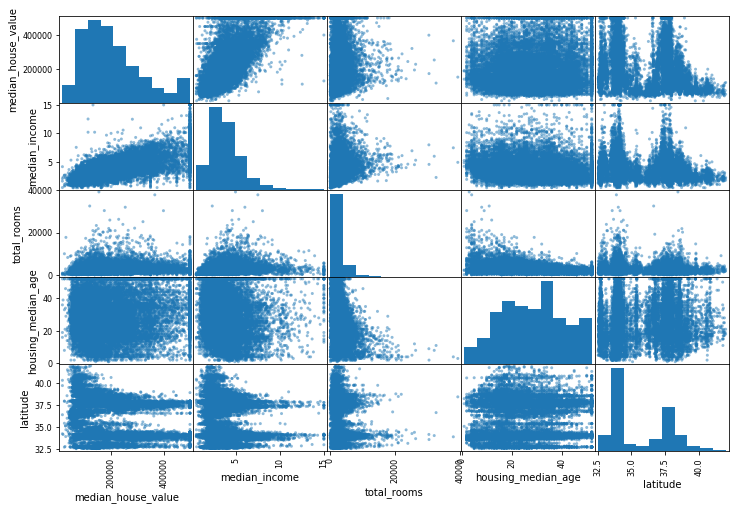

In [142]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'latitude']
scatter_matrix(strat_train_set_copy[attributes], figsize=(12,8))
plt.show()

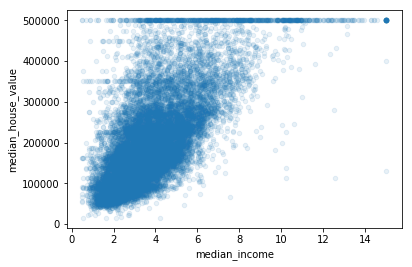

In [143]:
strat_train_set_copy.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

### Attribute combinations

In [144]:
strat_train_set_copy['rooms_per_household'] = strat_train_set_copy.total_rooms / strat_train_set_copy.households
strat_train_set_copy['bedrooms_per_room'] = strat_train_set_copy.total_bedrooms / strat_train_set_copy.total_rooms
strat_train_set_copy['population_per_household'] = strat_train_set_copy.population / strat_train_set_copy.households
corr_matrix = strat_train_set_copy.corr()
print(corr_matrix.median_house_value.sort_values(ascending=False))

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(strat_train_set_copy.values)
housing_extra_attribs

median_house_value          1.000000
median_income               0.689119
rooms_per_household         0.144505
total_rooms                 0.130815
housing_median_age          0.107693
households                  0.062810
total_bedrooms              0.046847
population_per_household   -0.019423
population                 -0.027620
longitude                  -0.053532
latitude                   -0.138384
bedrooms_per_room          -0.257837
Name: median_house_value, dtype: float64


array([[-117.25, 32.73, 38.0, ..., 2.2367491166077738, 6.501766784452297,
        2.2367491166077738],
       [-117.07, 32.63, 37.0, ..., 2.520286396181384, 5.6610978520286395,
        2.520286396181384],
       [-122.08, 37.35, 35.0, ..., 2.8994708994708995, 7.126984126984127,
        2.8994708994708995],
       ..., 
       [-121.69, 36.96, 23.0, ..., 2.961206896551724, 5.297413793103448,
        2.961206896551724],
       [-118.15, 34.04, 33.0, ..., 3.3535353535353534, 4.1313131313131315,
        3.3535353535353534],
       [-121.4, 36.84, 40.0, ..., 2.6728971962616823, 4.396261682242991,
        2.6728971962616823]], dtype=object)

### Data cleaning

In [145]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set.median_house_value.copy()

In [146]:
# remove the districts that are missing the total_bedroom attribute
housing.dropna(subset=['total_bedrooms'])

# remove the total_bedroom attribute
housing.drop('total_bedrooms', axis=1)

# set the missing attributes to some value (zero, mean, median, etc)
total_bedrooms_median = housing.total_bedrooms.median()
housing.total_bedrooms.fillna(total_bedrooms_median, inplace=True)

# replace missing values using the Imputer class
housing_imputer = Imputer(strategy='median')
housing_numeric_values = housing.drop('ocean_proximity', axis=1)
housing_imputer.fit(housing_numeric_values)

print(housing_imputer.statistics_)
print(housing_numeric_values.median().values)

housing_transformed = housing_imputer.transform(housing_numeric_values)
housing_transformed_df = pd.DataFrame(housing_transformed, columns=housing_numeric_values.columns)

# convert the text column to numbers and one-hot encode
housing_op_encoded, housing_op_categories = housing.ocean_proximity.factorize()
one_hot_encoder = OneHotEncoder()
housing_op_one_hot = one_hot_encoder.fit_transform(housing_op_encoded.reshape(-1, 1))

print(housing_op_encoded)
print(housing_op_categories)


[ -118.49       34.26       29.       2122.        434.       1164.        409.
     3.53715]
[ -118.49       34.26       29.       2122.        434.       1164.        409.
     3.53715]
[0 0 1 ..., 3 3 2]
Index(['NEAR OCEAN', 'NEAR BAY', 'INLAND', '<1H OCEAN', 'ISLAND'], dtype='object')


In [147]:
print(housing.total_rooms.describe())

count    16512.000000
mean      2629.966994
std       2158.319202
min          2.000000
25%       1448.000000
50%       2122.000000
75%       3147.250000
max      39320.000000
Name: total_rooms, dtype: float64


### Transformation pipeline

In [148]:
num_attribs = list(housing_numeric_values)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    # replace missing values using the Imputer class
    ('imputer', Imputer(strategy='median')),
    # add combined attributes
    ('attribs_adder', CombinedAttributesAdder()),
    # standardize features
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

housing_num_tr = num_pipeline.fit_transform(housing_numeric_values)
housing_prepared = full_pipeline.fit_transform(housing)

print(housing_prepared[:2])
print(housing_labels[:2])

[[ 1.15642472 -1.36119737  0.73868707 -0.36602135 -0.58664087 -0.71183193
  -0.56702581  0.547657    0.41186354 -0.07736035 -0.85067865  0.          0.
   0.          0.          1.        ]
 [ 1.24603871 -1.40804315  0.65916535 -0.11952579 -0.219769   -0.32990077
  -0.20902748 -0.05950591  0.0859954  -0.05060689 -0.40461757  0.          0.
   0.          0.          1.        ]]
14374    383600.0
14884    145500.0
Name: median_house_value, dtype: float64


### Select a model and train

In [149]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [150]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_rmse

0.0

In [151]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [152]:
def display_scores(scores):
    print('Scores: %s' % scores)
    print('Mean: %s' % scores.mean())
    print('Standard deviation: %s' % scores.std())

In [153]:
display_scores(tree_rmse_scores)

Scores: [ 68967.33831074  70171.12236328  68466.24094338  67507.89624116
  69559.17841083  75132.26683881  69610.08043927  71830.47560983
  70367.15305446  70136.47703283]
Mean: 70174.8229245
Standard deviation: 1988.55808598


In [154]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
display_scores(forest_rmse)

Scores: 22439.3405795
Mean: 22439.3405795
Standard deviation: 0.0


In [155]:
# lin_reg = LinearRegression()
# lin_reg.fit(housing_prepared, housing_labels)

### Save model

In [158]:
joblib.dump(forest_reg, join(DATA_DIR, 'forest_reg.pkl'))

['../data/housing/forest_reg.pkl']

### Fine tune model

In [175]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50, 70, 100], 'max_features': [2, 4, 6, 8, 10, 12]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(housing_prepared, housing_labels) # long operation

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 50, 70, 100], 'max_features': [2, 4, 6, 8, 10, 12]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [176]:
print(grid_search.best_params_)
grid_search.best_estimator_

{'max_features': 6, 'n_estimators': 70}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [177]:
best_forest_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
best_forest_reg.fit(housing_prepared, housing_labels)
best_predictions = best_forest_reg.predict(housing_prepared)
best_forest_rmse = np.sqrt(mean_squared_error(housing_labels, best_predictions))
display_scores(best_forest_rmse)

Scores: 18517.4231481
Mean: 18517.4231481
Standard deviation: 0.0


### Analyze model

In [178]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.79692971e-02,   6.29772247e-02,   4.16353565e-02,
         1.91610126e-02,   1.76485804e-02,   1.79405748e-02,
         1.54499067e-02,   3.12765586e-01,   5.90567240e-02,
         1.02849585e-01,   8.87546629e-02,   1.07558846e-02,
         1.64990631e-01,   2.37682798e-04,   3.46724274e-03,
         4.34004850e-03])

In [179]:
extra_attribs = ['rooms_per_household', 'pop_per_household', 'bedrooms_per_room']
cat_encoder = cat_pipeline.named_steps.cat_encoder
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31276558619014128, 'median_income'),
 (0.16499063095962099, 'INLAND'),
 (0.10284958463804238, 'pop_per_household'),
 (0.088754662859135303, 'bedrooms_per_room'),
 (0.077969297055642844, 'longitude'),
 (0.062977224684424668, 'latitude'),
 (0.059056723983009464, 'rooms_per_household'),
 (0.041635356477439704, 'housing_median_age'),
 (0.019161012558009213, 'total_rooms'),
 (0.017940574841269191, 'population'),
 (0.017648580443973463, 'total_bedrooms'),
 (0.015449906711376662, 'households'),
 (0.010755884553115396, '<1H OCEAN'),
 (0.0043400485018623191, 'NEAR OCEAN'),
 (0.0034672427448710478, 'NEAR BAY'),
 (0.0002376827980660078, 'ISLAND')]

### Predict using the test data

In [182]:
x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set.median_house_value.copy()
x_test_prepared = full_pipeline.transform(x_test)
final_predictions = best_forest_reg.predict(x_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

47888.862271315607